# Electricity Usage Prediction

## Introduction

In a world where sustainable development goals (SGD) are of paramount importance, it is crucial for stakeholders to predict the energy usage in advance so as to maximise energy utilisation. This project attempts to address this problem by regressing energy usage against weather conditions, a feature that should provide an abundance of information towards electricity consumption.

## Preliminary Work

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from datetime import datetime
from sklearn.metrics import f1_score

In [97]:
energy = pd.read_csv('energy_data.csv')
weather = pd.read_csv('weather_data.csv')

The records in energy_data.csv are measured half-hourly. We first sum up the energy usage to get per day usage and merge it with weather data. 

In [98]:
def getdate1(datetime):
    return datetime.split()[0]
def gettime(datetime):
    return datetime.split()[1]
energy['Date'] = energy['Date & Time'].apply(getdate1)
energy['Time'] = energy['Date & Time'].apply(gettime)

In [99]:
daily_use = energy.groupby('Date').sum()['use [kW]']
daily_use

Date
2014-01-01    65.013592
2014-01-02    32.305336
2014-01-03    31.164468
2014-01-04    45.287782
2014-01-05    36.316643
                ...    
2014-12-27    35.046127
2014-12-28    37.695824
2014-12-29    28.675929
2014-12-30    31.514313
2014-12-31    28.674498
Name: use [kW], Length: 365, dtype: float64

The records in weather_data.csv are hourly data. Therefore, we calculate the daily mean values to convert it to daily records.

In [100]:
def getdate2(timestamp):
    return datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d')
weather['Date'] = weather['time'].apply(getdate2)

In [101]:
merged = pd.concat([weather.groupby('Date').mean(), daily_use], axis=1).drop('time', axis=1)
merged

,temperature,humidity,visibility,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,use [kW]
Date,,,,,,,,,,,
2014-01-01,20.110833,0.556667,9.970000,1025.395000,6.820417,0.031304,252.291667,0.000000,6.362083,0.000000,65.013592
2014-01-02,16.382500,0.784583,3.834583,1023.465833,7.433750,0.354444,53.458333,0.002004,10.737083,0.074583,32.305336
2014-01-03,6.256667,0.680833,4.509167,1014.428750,12.828333,0.186364,207.333333,0.002029,-2.337500,0.080000,31.164468
2014-01-04,2.711667,0.617083,9.822917,1030.096250,5.248333,0.001667,240.166667,0.000000,-8.352083,0.000000,45.287782
2014-01-05,17.654167,0.682083,9.134583,1025.275000,3.417083,0.010952,208.958333,0.000033,8.615000,0.000417,36.316643
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,35.487083,0.756250,9.246250,1022.081667,3.677083,0.030417,243.791667,0.000000,27.992500,0.000000,35.046127
2014-12-28,41.892917,0.763750,9.332917,1013.549167,6.587917,0.245909,224.458333,0.003996,34.876250,0.137917,37.695824
2014-12-29,34.728333,0.592083,9.997083,1018.870833,8.129583,0.119167,281.833333,0.000000,21.570000,0.000000,28.675929


We aim to predict the usage for each day in December using the weather data, so the training set will contain data from January to November, while the testing set will contain December only.

In [102]:
train = merged.loc[: '2014-11-30', :]
x_train = train.drop('use [kW]', axis=1)
y_train = train.loc[:, 'use [kW]']
test = merged.loc['2014-12-01': , :]
x_test = test.drop('use [kW]', axis=1)
y_test = test.loc[:, 'use [kW]']

We aim to predict the temperature for each day in December, so the training set will contain data from January to November, while the testing set will contain December only. The only dependent variable is temperature. Other numerical fields in the weather data is used as an independent variable.

In [103]:
def classification_threshold(temp):
    return 1 if temp >= 35 else 0
    
x_train_temp = x_train.drop('temperature', axis=1)
y_train_temp = x_train.loc[:, 'temperature'].apply(classification_threshold)
x_test_temp = x_test.drop('temperature', axis=1)
y_test_temp = x_test.loc[:, 'temperature'].apply(classification_threshold)

## Predicting Energy Usage

With the data set ready, we will now train a linear regression model, and then predict energy usage for each day in the month of December using features from weather data.

Note the normalisation layer in the network. When creating a model with multiple features, the values of each feature should cover roughly the same range. For example, if one feature's range spans 500 to 100,000 and another feature's range spans 2 to 12, then the model will be difficult or impossible to train. Therefore, you should normalize features in a multi-feature model. (Google Machine Learning Crash Course)

In [104]:
normalizer = layers.experimental.preprocessing.Normalization(axis=None, input_shape=[10,])
normalizer.adapt(np.array(x_train))

In [105]:
energy_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1, dtype='float64'),])

energy_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

history = energy_model.fit(
    x_train,
    y_train,
    verbose=0,
    epochs=100,
    validation_split = 0.2)

We define a function to plot the train and validation loss.

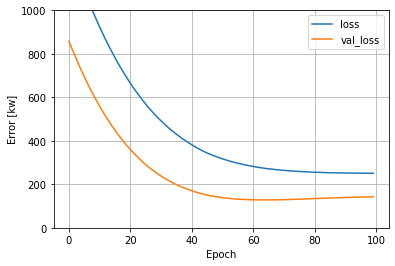

In [106]:
def plot_loss(history, lim):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, lim])
    plt.xlabel('Epoch')
    plt.ylabel('Error [kw]')
    plt.legend()
    plt.grid(True)
  
plot_loss(history, 1000)
plt.show()

After training the model, we evaluate its performance using root MSE loss on December data.

In [107]:
mse = energy_model.evaluate(x_test, y_test, verbose=0)
print(f'The root mean squared error = {np.sqrt(mse)}.')

The root mean squared error = 7.132660077608833.


We can also create a csv dump for the predicted values in December.

In [108]:
pred = energy_model.predict(x_test, verbose=0)
dump = pd.DataFrame(y_test)
dump['pred use [kW]'] = pred
dump.to_csv('lrdump.csv')

## Temperature classification

Using only weather data we will classify if the temperature is high or low based on numerical fields.

In [109]:
normalizer = layers.experimental.preprocessing.Normalization(axis=None, input_shape=[9,])
normalizer.adapt(np.array(x_train_temp))

In [110]:
weather_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1, dtype='float64', activation=tf.sigmoid),])

weather_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"])

history = weather_model.fit(
    x_train_temp,
    y_train_temp,
    verbose=0,
    epochs=100,
    validation_split = 0.2)

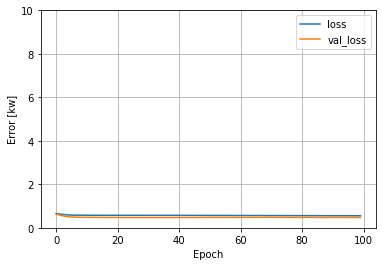

In [111]:
plot_loss(history, 10)
plt.show()

In [115]:
pred = weather_model.predict(x_test_temp)
pred = [1 if x >= 0.5 else 0 for x in pred]
f1_score(y_test_temp, pred)
dump = pd.DataFrame(y_test_temp)
dump['Hot'] = pred
dump.to_csv('logisticdump.csv')

## Energy usage data Analysis

We will now analyze how different devices are being used in different times of the day.

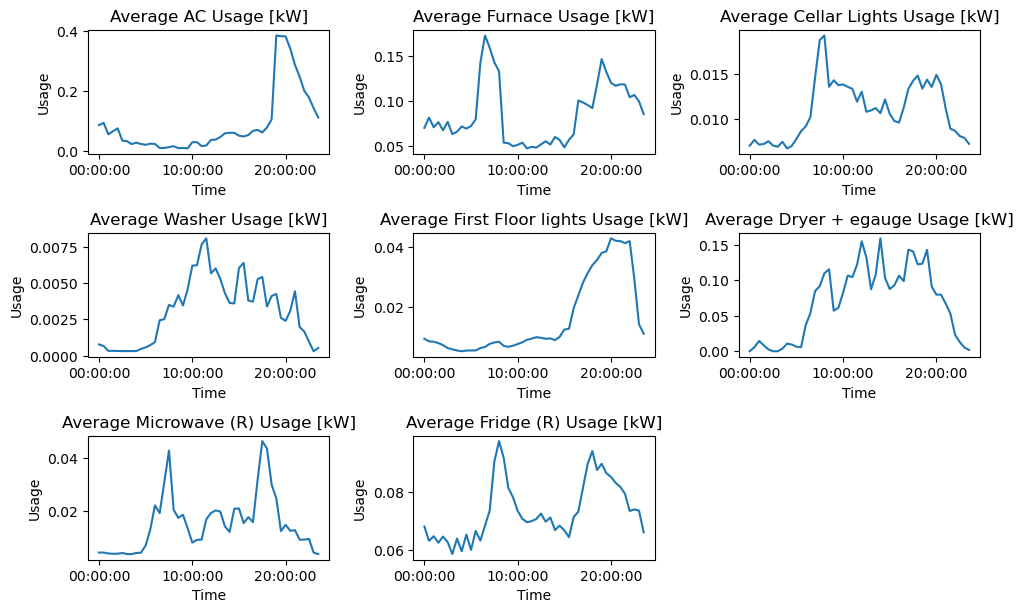

In [113]:
devices = ['AC', 'Furnace', 'Cellar Lights', 'Washer', 'First Floor lights', 'Dryer + egauge', 'Microwave (R)', 'Fridge (R)']

fig = plt.figure(dpi=100, figsize=(10, 20), tight_layout=True)
for i, device in enumerate(devices):
    ax = fig.add_subplot(10, 3, i + 1)
    energy.groupby('Time').mean()[f'{device} [kW]'].plot(title=f'Average {device} Usage [kW]', ax=ax)
    ax.set_ylabel('Usage')
    ax.set_xlabel('Time')

plt.show()

We can draw the conclusions from the charts above:
- The washer is not only used during the day. However, it is true that its usage from 21:30 to 06:00 is much lower than that of other times in the day.
- During the night, at around 7pm to 8pm, the AC is used the most.
- Floor lights are used more at night than during the day, while cellar lights have peak usage in the morning and at night.
- The fridge has peak usage in the morning and at night. This may be due to making breakfast and dinner require frequently retrieving food from the fridge.